In [1]:
import sys
assert sys.version_info >= (3, 6), "Sonnet 2 requires Python >=3.6"

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tree
import pandas as pd

try:
  import sonnet.v2 as snt
  tf.enable_v2_behavior()
except ImportError:
  import sonnet as snt

print("TensorFlow version {}".format(tf.__version__))
print("Sonnet version {}".format(snt.__version__))

TensorFlow version 2.3.1
Sonnet version 2.0.0


In [4]:
!pwd

/Users/tuckerkj/git/quantumML/python


In [6]:
is_data = pd.read_table('/Users/tuckerkj/Google Drive/Research/QML/data/quc_examples/Tutorial1_TrainPosRealWaveFunction/tfim1d_data.txt', delimiter=' ', usecols=range(10)).values
is_train = is_data[0:7999]
is_test = is_data[8000:9999]

In [7]:
is_train.shape

(7999, 10)

In [8]:
original_dim = is_train.shape[1]

In [329]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 100
batch_size = 128
latent_dim = 10
epochs = 50

In [99]:
class Encoder(snt.Module):
    def __init__(self, hdims, latent_dim, name=None):
        super(Encoder, self).__init__(name)
        
        self.hidden = []
        for idx, hdim in enumerate(hdims):
            layer_name = 'hidden{}'.format(idx)
            self.hidden.append(snt.Linear(hdim, name=layer_name))
            
        self.z_mean = snt.Linear(latent_dim, name='z_mean')
        self.z_log_var = snt.Linear(latent_dim, name='z_log_var')
        
    def __call__(self, x):
        
        # Run the input through the encoder network
        for hidden_layer in self.hidden:
            x = tf.nn.relu(hidden_layer(x))
        
        # Use the reparameterization trick to calculate the latent variables
        out_mean = self.z_mean(x)
        out_log_var = self.z_log_var(x)
        
        eps = tf.random.normal(out_mean.shape, mean=0.0, stddev=1.0, dtype=tf.dtypes.double)
        out_z = eps*tf.exp(0.5*out_log_var) + out_mean
        
        return {
            'mean': out_mean,
            'log_var': out_log_var,
            'z': out_z
        }

In [100]:
enc = Encoder([intermediate_dim], latent_dim)

In [101]:
output = enc(is_train.astype(float))

In [102]:
output['z']

<tf.Tensor: shape=(7999, 4), dtype=float64, numpy=
array([[-0.84969135, -0.14474033,  0.94266648, -1.33234972],
       [ 1.59825231,  1.27660613, -0.59592931,  0.44321434],
       [-1.16510074,  0.44970454,  0.49334116,  2.55032563],
       ...,
       [-0.70828427,  0.56456185, -0.09377427, -0.41238832],
       [ 1.07908452,  0.89689959,  0.55525758, -0.81118676],
       [ 0.80897817, -0.79185813, -0.88526631, -1.26299141]])>

In [103]:
output['z'].shape

TensorShape([7999, 4])

In [122]:
class Decoder(snt.Module):
    def __init__(self, hdims, vdim, apply_sigmoid=False, name=None):
        super(Decoder, self).__init__(name)
        
        self.apply_sigmoid = apply_sigmoid
        
        self.hidden = []
        for idx, hdim in enumerate(hdims):
            layer_name = 'hidden{}'.format(idx)
            self.hidden.append(snt.Linear(hdim, name=layer_name))
            
        self.visible = snt.Linear(vdim, 'visible')
        
    def __call__(self, x):
        
        for hidden_layer in self.hidden:
            x = tf.nn.relu(hidden_layer(x))
        
        if self.apply_sigmoid:
            output = tf.nn.sigmoid(self.visible(x))
        else:
            output = self.visible(x)
        
        return output

In [222]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.cast(tf.math.log(2. * np.pi), tf.float64)

    return tf.reduce_sum(
        -.5 * ((sample - mean) ** tf.cast(2., tf.float64) * tf.cast(tf.exp(-logvar), tf.float64) + logvar + log2pi),
        axis=raxis)

In [223]:
class VAE(snt.Module):
    def __init__(self, encoder, decoder, name=None):
        super(VAE, self).__init__(name)
        
        self.encoder = encoder
        self.decoder = decoder
                
    def __call__(self, x):
        # Run the encoder and decoder
        encoder_output = self.encoder(x)
        x_recon = self.decoder(encoder_output['z'])
        
        # Compute the loss function
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_recon, labels=x)
        log_pxz = -tf.reduce_sum(cross_ent, axis=1)
        log_pz = log_normal_pdf(encoder_output['z'], tf.cast(0.0, tf.float64), tf.cast(0.0, tf.float64))
        log_qzx = log_normal_pdf(encoder_output['z'], encoder_output['mean'], encoder_output['log_var'])
        loss = -tf.reduce_mean(log_pxz + log_pz - log_qzx)
        
        return {
            'x_recon': x_recon,
            'loss': loss
        }

In [224]:
dec = Decoder([intermediate_dim], original_dim, True)

In [225]:
out_vae = dec(out_mean)

In [226]:
out_vae

<tf.Tensor: shape=(7999, 10), dtype=float64, numpy=
array([[0.49805634, 0.56821103, 0.50252593, ..., 0.48917527, 0.49358371,
        0.50441736],
       [0.53601288, 0.5935486 , 0.50996864, ..., 0.58233535, 0.53262848,
        0.60569744],
       [0.5478654 , 0.61765784, 0.51126612, ..., 0.57514374, 0.53254697,
        0.60227551],
       ...,
       [0.52100069, 0.58701677, 0.50656475, ..., 0.51436673, 0.50555004,
        0.52687339],
       [0.48744812, 0.52148054, 0.50447984, ..., 0.4845681 , 0.50866468,
        0.45236271],
       [0.47266674, 0.5267072 , 0.49364781, ..., 0.48846628, 0.51004165,
        0.43183574]])>

In [227]:
vae = VAE(enc, dec)

In [247]:
model_output = vae(is_test.astype(float))

In [248]:
model_output

{'x_recon': <tf.Tensor: shape=(1999, 10), dtype=float64, numpy=
 array([[-2.41030074, -3.95024537, -4.11566051, ..., -2.13874472,
         -0.05711204,  0.65082204],
        [ 1.93131619,  3.65198849,  3.6826388 , ...,  5.53376829,
          4.68197597,  2.42143408],
        [-0.06304897, -1.015196  , -3.01258011, ..., -2.76105152,
         -0.43423799,  0.81827818],
        ...,
        [-0.44084999, -0.44696913, -0.18770231, ...,  2.62859023,
          1.88377851,  0.9240937 ],
        [ 3.05381366,  3.74502294,  1.39615498, ...,  1.20114837,
          0.36089653, -0.14511819],
        [ 0.61598874,  1.84835129,  2.45726687, ...,  0.88366842,
         -0.96806828, -1.01429355]])>,
 'loss': <tf.Tensor: shape=(), dtype=float64, numpy=5.460200439432734>}

## Training

In [230]:
#@title Utility function to show progress bar.
from tqdm import tqdm

num_meas = is_train.shape[0]

def progress_bar(generator):
  return tqdm(
      generator,
      unit='measurements',
      unit_scale=batch_size,
      total=(num_meas // batch_size) * epochs)

In [420]:
# network parameters
learning_rate = 3e-4
input_shape = (original_dim, )
batch_size = 128
epochs = 50

# F = 0.9322
#intermediate_dim = [500, 500]
#latent_dim = 10

# F = 0.9255
#intermediate_dim = [100]
#latent_dim = 4

# F = 0.8960
intermediate_dim = [100]
latent_dim = 2

optimizer = snt.optimizers.Adam(learning_rate=learning_rate)

enc = Encoder(intermediate_dim, latent_dim)
dec = Decoder(intermediate_dim, original_dim, apply_sigmoid=False)
vae = VAE(enc, dec)

@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        model_output = vae(tf.cast(data, tf.float64))
    
    trainable_variables = vae.trainable_variables
    grads = tape.gradient(model_output['loss'], trainable_variables)
    optimizer.apply(grads, trainable_variables)
    
    return model_output

In [421]:
# Get data sliced for SGD
train_dataset = (
    tf.data.Dataset.from_tensor_slices(is_train)
    .shuffle(1000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size, drop_remainder=True)
    .prefetch(-1))

valid_dataset = (
    tf.data.Dataset.from_tensor_slices(is_test)
    .repeat(1)  # 1 epoch
    .batch(batch_size)
    .prefetch(-1))

In [422]:
# Train
num_training_updates = 10000

train_losses = []
for step_index, data in enumerate(train_dataset):
    train_results = train_step(data)
    train_losses.append(train_results['loss'])
    
    if (step_index + 1) % 100 == 0:
        print('%d loss: %f' % (step_index+1, np.mean(train_losses[-100:])))
        
    if (step_index + 1) % num_training_updates == 0:
        break

100 loss: 7.107139
200 loss: 6.837475
300 loss: 6.468705
400 loss: 6.106451
500 loss: 5.889377
600 loss: 5.736328
700 loss: 5.655909
800 loss: 5.615973
900 loss: 5.608233
1000 loss: 5.593127
1100 loss: 5.593059
1200 loss: 5.575189
1300 loss: 5.572523
1400 loss: 5.579803
1500 loss: 5.558306
1600 loss: 5.563815
1700 loss: 5.553054
1800 loss: 5.553945
1900 loss: 5.566949
2000 loss: 5.553439
2100 loss: 5.546667
2200 loss: 5.541650
2300 loss: 5.543150
2400 loss: 5.545446
2500 loss: 5.534047
2600 loss: 5.541222
2700 loss: 5.536140
2800 loss: 5.523810
2900 loss: 5.521954
3000 loss: 5.536422
3100 loss: 5.526103
3200 loss: 5.521861
3300 loss: 5.509240
3400 loss: 5.523168
3500 loss: 5.518260
3600 loss: 5.502752
3700 loss: 5.518474
3800 loss: 5.506137
3900 loss: 5.508169
4000 loss: 5.503486
4100 loss: 5.502119
4200 loss: 5.494003
4300 loss: 5.505451
4400 loss: 5.498805
4500 loss: 5.504747
4600 loss: 5.502274
4700 loss: 5.490805
4800 loss: 5.491975
4900 loss: 5.487374
5000 loss: 5.495957
5100 loss

# Results

In [423]:
# Look at validation set
model_output = vae(is_test.astype(float))
print(model_output)

{'x_recon': <tf.Tensor: shape=(1999, 10), dtype=float64, numpy=
array([[-1.15555135, -2.28309331, -3.39881238, ..., -5.36151021,
        -3.84417411, -2.26800649],
       [ 2.61029521,  4.15596546,  5.37306001, ...,  3.44777419,
         2.33987908,  1.35133921],
       [-0.72117272, -1.46636052, -2.16848412, ..., -2.83993942,
        -2.0107764 , -1.1457437 ],
       ...,
       [ 0.32957333,  0.71279641,  1.34065278, ...,  3.52310261,
         2.78305755,  1.58827116],
       [ 1.15229907,  2.01513082,  2.49528062, ...,  0.02408877,
        -0.34563325, -0.22157435],
       [ 1.45244776,  2.53327156,  3.09664805, ...,  0.2887978 ,
        -0.16116833, -0.11991914]])>, 'loss': <tf.Tensor: shape=(), dtype=float64, numpy=5.544480399641831>}


In [407]:
def bit_array(a):
    aa = []
    for c in a:
        if c == '0':
            aa.append(0)
        else:
            aa.append(1)
        
    return np.array(aa)

def bin_to_dec(b):
    dec = 0
    for idx, val in enumerate(b):
        dec += val << (len(b) - idx - 1)
        
    return dec

def update_counts(psi, vae, batch_size):
    latent_dim = vae.decoder.hidden[0].input_size
    z = tf.random.normal([batch_size, latent_dim], mean=0.0, stddev=1.0, dtype=tf.dtypes.double)
    output = tf.nn.sigmoid(vae.decoder(z))
    
    #meas = tf.math.round(tf.nn.sigmoid(vae.decoder(z)))
    #meas_int = meas.numpy().astype(int)
    
    eps = tf.random.uniform(output.shape, minval=0, maxval=1, dtype=tf.dtypes.float64)
    meas_int = tf.cast(tf.math.greater_equal(output, eps), tf.int32).numpy()
    
    for ii in range(meas_int.shape[0]):
        idx = bin_to_dec(meas_int[ii,:])
        psi[idx] += 1

def get_psi(vae, num_samples):
    n = vae.encoder.hidden[0].input_size
    psi = np.zeros(2**n)
    batch_size = 1000
    total_samples = 0
    while total_samples < num_samples:
        update_counts(psi, vae, batch_size)
        total_samples = total_samples + batch_size
        
    # Normalize
    psi = np.sqrt(psi*(1.0/float(total_samples)))
    
    return psi

import math
def get_psi_loss(vae, num_samples):
    n = vae.encoder.hidden[0].input_size
    norm = 0
    psi = []
    for d in range(2**n):
        dbin = bit_array(np.binary_repr(d, width=n))
        dbin_input = np.tile(dbin, (num_samples,1))
        model_output = vae(dbin_input.astype(float))
        val = np.exp(-0.5*model_output['loss'])
        psi.append(val)
        norm = norm + val*val
    norm = math.sqrt(norm)
    
    for ii in range(len(psi)):
        psi[ii] = psi[ii]/norm
        
    return np.array(psi)

In [424]:
psi = get_psi(vae, 1000000)

In [384]:
psi = get_psi_loss(vae, 100)

In [425]:
np.dot(psi, psi)

1.0

In [426]:
psi

array([0.27563926, 0.14995333, 0.10682228, ..., 0.10760112, 0.1460137 ,
       0.28645768])

In [427]:
# Save the wave function
np.savetxt('/Users/tuckerkj/Google Drive/Research/QML/data/quc_examples/Tutorial1_TrainPosRealWaveFunction/ld_results/new_vae_psi_2d.txt', psi)


In [431]:
tf.constant([0.0,0.0], dtype=tf.dtypes.float64)

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0., 0.])>

In [434]:
tf.nn.sigmoid(vae.decoder(tf.constant([[0.0,0.0]], dtype=tf.dtypes.float64))).numpy()

array([[0.49948223, 0.47909102, 0.4631004 , 0.48189872, 0.50126455,
        0.52136611, 0.53988155, 0.50752295, 0.48625074, 0.48328118]])

# Latent Space Visualization

In [435]:
def plot_qvae_results(vae, z_min, z_max, frame_size = 0, fig_size = 10, fig_bkgrnd = 1):
    """Plots spins as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        frame_size: width of space between spin images
    """

    #encoder, decoder = models
    #x_test, y_test = data
    #os.makedirs(model_name, exist_ok=True)

    #filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    #z_mean, _, _ = encoder.predict(x_test,
    #                               batch_size=batch_size)
    #plt.figure(figsize=(12, 10))
    #plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    #plt.colorbar()
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    #plt.savefig(filename)
    #plt.show()

    #filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of spin distributions
    n = 30
    digit_size = 10
    figure = np.zeros(((frame_size + digit_size) * n + frame_size,
                       (frame_size + digit_size) * n + frame_size)) + fig_bkgrnd
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(z_min[0], z_max[0], n)
    grid_y = np.linspace(z_min[1], z_max[1], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = tf.constant([[xi, yi]], dtype=tf.dtypes.float64)
            x_decoded = tf.nn.sigmoid(vae.decoder(z_sample)).numpy()
            #print(x_decoded[0].shape)
            digit = np.stack([x_decoded[0] for ii in range(digit_size)]).reshape(digit_size, digit_size)
            figure[i * (frame_size + digit_size) + frame_size: (i + 1) * (digit_size + frame_size),
                   j * (frame_size + digit_size) + frame_size: (j + 1) * (digit_size + frame_size)] = digit

    plt.figure(figsize=(fig_size, fig_size))
    start_range = (digit_size + frame_size) // 2
    end_range = (n - 1) * (digit_size + frame_size) + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size + frame_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='gray', vmin=0, vmax=1)
    #plt.savefig(filename)
    plt.show()

In [436]:
def plot_qvae_latent(vae, z):
    """Plots spins for the given 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        z (tuple): latent vector
    """

    #encoder, decoder = models

    img_height = 10

    z_sample = tf.constant([z], dtype=tf.dtypes.float64)
    x_decoded = tf.nn.sigmoid(vae.decoder(z_sample)).numpy()
    spin_img = np.stack([x_decoded[0] for ii in range(img_height)]).reshape(img_height, img_height)

    #print(spin_img)

    plt.figure(figsize=(10, 4))
    plt.imshow(spin_img, cmap='gray', vmin=0, vmax=1)
    plt.show()

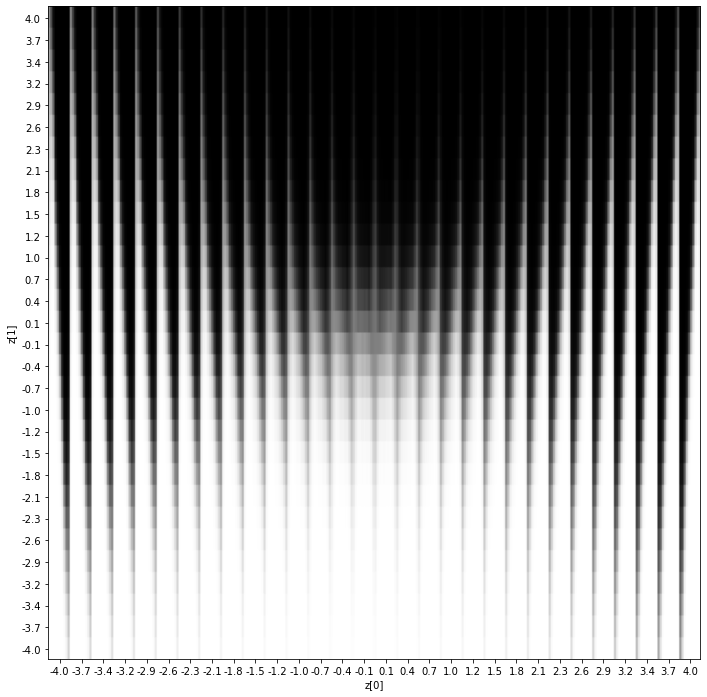

In [437]:
plot_qvae_results(vae, [-4,-4], [4,4], 0, 12, 0.3)

# Scratch

In [34]:
a = ['a','b','c']
for idx, val in enumerate(a):
    print(idx, val)

0 a
1 b
2 c


In [21]:
lin = snt.Linear(intermediate_dim, name='test_lin')

In [27]:
lin(is_train.astype(float))

<tf.Tensor: shape=(7999, 100), dtype=float64, numpy=
array([[-0.46892147, -0.34728384, -0.74378709, ...,  0.29133378,
        -0.26331127,  0.37414721],
       [-0.04339453,  0.07576071, -1.16743727, ...,  0.93418193,
         0.12609772,  0.85569389],
       [ 0.02504136,  0.50216652, -1.25031824, ...,  0.6404713 ,
         0.64565024,  0.74596843],
       ...,
       [ 0.15872905,  0.34844972, -1.76310892, ...,  0.21092538,
         0.73613504,  0.02295605],
       [ 0.31660287,  0.42498682, -0.7207022 , ..., -0.56906129,
         0.97862829, -0.26926874],
       [ 1.17475972,  0.32786622, -1.34069384, ...,  0.04867342,
         0.99408893, -0.87915178]])>